## 1. 라이브러리 로드

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료")

라이브러리 로드 완료


## 2. 전처리된 데이터 로드

In [11]:
# 전처리된 데이터 로드
train = pd.read_csv('train_processed.csv')
test = pd.read_csv('test_processed.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTrain columns: {len(train.columns)}개")
print(f"Test columns: {len(test.columns)}개")

Train shape: (3008016, 59)
Test shape: (28512, 58)

Train columns: 59개
Test columns: 58개


## 3. 학습용 데이터 준비

In [12]:
# Target과 Features 분리
y = train['sales'].copy()
X = train.drop(['sales', 'date', 'id'], axis=1, errors='ignore')

# 컬럼 이름에서 특수문자 제거 (LightGBM 호환성)
X.columns = X.columns.str.replace(r'[^\w\s]', '_', regex=True).str.replace(r'\s+', '_', regex=True)

# 범주형 컬럼 인코딩
from sklearn.preprocessing import LabelEncoder

categorical_columns = X.select_dtypes(include=['object']).columns
print(f"범주형 컬럼: {list(categorical_columns)}")

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)}개 카테고리")

# Test 데이터에서도 같은 컬럼명과 인코딩 적용
test[['test_id']] = test[['id']].copy() if 'id' in test.columns else None
test.columns = test.columns.str.replace(r'[^\w\s]', '_', regex=True).str.replace(r'\s+', '_', regex=True)
test_X = test[X.columns].copy()
for col in categorical_columns:
    test_X[col] = label_encoders[col].transform(test_X[col].astype(str))
test_id = test['id'].copy() if 'id' in test.columns else test.index

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Test X shape: {test_X.shape}")
print(f"\nFeature 컬럼 수: {X.shape[1]}")

범주형 컬럼: ['city', 'state']
  city: 22개 카테고리
  state: 16개 카테고리

X shape: (3008016, 56)
y shape: (3008016,)
Test X shape: (28512, 56)

Feature 컬럼 수: 56


## 4. Train/Validation 데이터 분할

In [13]:
# 시계열 데이터이므로 시간 순서대로 분할
# 전체의 80%를 학습, 20%를 검증에 사용
split_idx = int(len(X) * 0.8)

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (2406412, 56)
X_val shape: (601604, 56)
y_train shape: (2406412,)
y_val shape: (601604,)


## 5. RMSLE 평가 함수

In [14]:
def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error 계산"""
    # 음수 값 처리: log(x+1) 사용
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 음수 예측값 처리
    y_pred = np.clip(y_pred, 0, None)
    
    msle = mean_squared_log_error(y_true, y_pred)
    return np.sqrt(msle)

print("RMSLE 함수 정의 완료")

RMSLE 함수 정의 완료


## 6. 베이스라인 모델 (평균값 예측)

In [15]:
# 간단한 베이스라인: 전체 평균값으로 예측
baseline_pred_val = np.full(len(y_val), y_train.mean())
baseline_score = rmsle(y_val, baseline_pred_val)

print(f"\n=== Baseline Model (평균값) ===")
print(f"Train 평균: {y_train.mean():.2f}")
print(f"Validation RMSLE: {baseline_score:.6f}")


=== Baseline Model (평균값) ===
Train 평균: 328.79
Validation RMSLE: 3.427781


## 7. XGBoost 모델 학습

In [16]:
from xgboost import XGBRegressor

# XGBoost 모델 초기화
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# 모델 학습
print("XGBoost 모델 학습 중...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 예측
xgb_val_pred = xgb_model.predict(X_val)
xgb_score = rmsle(y_val, xgb_val_pred)

print(f"\n=== XGBoost Model ===")
print(f"Validation RMSLE: {xgb_score:.6f}")
print(f"개선도: {(baseline_score - xgb_score) / baseline_score * 100:.2f}%")

XGBoost 모델 학습 중...



=== XGBoost Model ===
Validation RMSLE: 1.521931
개선도: 55.60%


## 8. LightGBM 모델 학습

In [17]:
from lightgbm import LGBMRegressor

# LightGBM 모델 초기화
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 모델 학습
print("LightGBM 모델 학습 중...")
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

# 예측
lgb_val_pred = lgb_model.predict(X_val)
lgb_score = rmsle(y_val, lgb_val_pred)

print(f"\n=== LightGBM Model ===")
print(f"Validation RMSLE: {lgb_score:.6f}")
print(f"개선도: {(baseline_score - lgb_score) / baseline_score * 100:.2f}%")

LightGBM 모델 학습 중...

=== LightGBM Model ===
Validation RMSLE: 1.573965
개선도: 54.08%


## 9. 모델 성능 비교

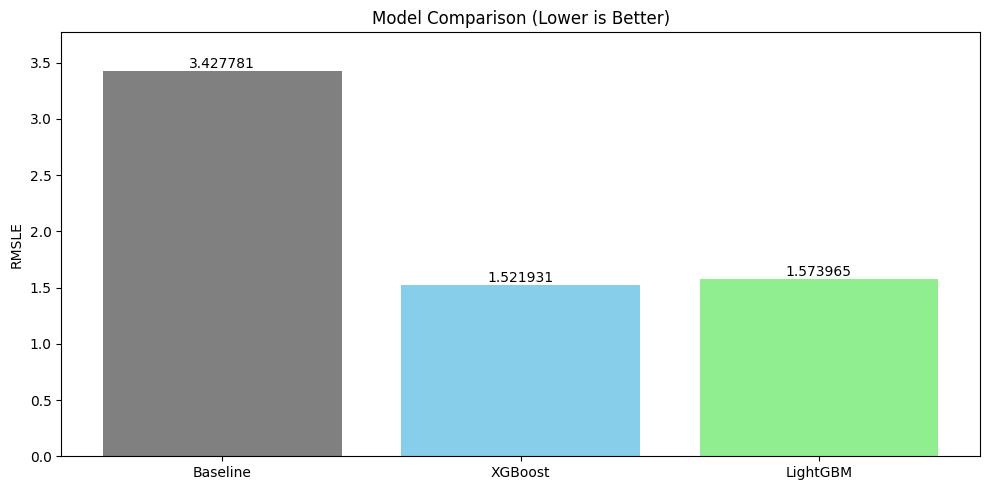


=== 최종 결과 ===
최고 성능 모델: XGBoost
Best RMSLE: 1.521931


In [18]:
import matplotlib.pyplot as plt

models = ['Baseline', 'XGBoost', 'LightGBM']
scores = [baseline_score, xgb_score, lgb_score]

plt.figure(figsize=(10, 5))
bars = plt.bar(models, scores, color=['gray', 'skyblue', 'lightgreen'])
plt.ylabel('RMSLE')
plt.title('Model Comparison (Lower is Better)')
plt.ylim(0, max(scores) * 1.1)

# 값 표시
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.6f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n=== 최종 결과 ===")
best_model_name = models[np.argmin(scores)]
best_score = min(scores)
print(f"최고 성능 모델: {best_model_name}")
print(f"Best RMSLE: {best_score:.6f}")

## 8.5. 하이퍼파라미터 최적화 (Optuna)

In [19]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

# Optuna 경고 제거
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Optuna를 이용한 하이퍼파라미터 최적화 시작...")

# XGBoost 최적화 함수
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    pred = model.predict(X_val)
    score = rmsle(y_val, pred)
    
    return score

# LightGBM 최적화 함수
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    pred = model.predict(X_val)
    score = rmsle(y_val, pred)
    
    return score

# XGBoost 최적화
print("\n=== XGBoost 최적화 (50 trials) ===")
sampler_xgb = TPESampler(seed=42)
study_xgb = optuna.create_study(
    sampler=sampler_xgb,
    pruner=MedianPruner(),
    direction='minimize'
)
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

best_params_xgb = study_xgb.best_params
best_score_xgb_opt = study_xgb.best_value

print(f"\n최적 XGBoost 파라미터:")
for key, value in best_params_xgb.items():
    print(f"  {key}: {value}")
print(f"최고 성능: {best_score_xgb_opt:.6f}")

# LightGBM 최적화
print("\n=== LightGBM 최적화 (50 trials) ===")
sampler_lgb = TPESampler(seed=42)
study_lgb = optuna.create_study(
    sampler=sampler_lgb,
    pruner=MedianPruner(),
    direction='minimize'
)
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

best_params_lgb = study_lgb.best_params
best_score_lgb_opt = study_lgb.best_value

print(f"\n최적 LightGBM 파라미터:")
for key, value in best_params_lgb.items():
    print(f"  {key}: {value}")
print(f"최고 성능: {best_score_lgb_opt:.6f}")


Optuna를 이용한 하이퍼파라미터 최적화 시작...

=== XGBoost 최적화 (50 trials) ===


Best trial: 7. Best value: 0.958021:  24%|██▍       | 12/50 [11:38<36:52, 58.23s/it]


[W 2025-12-15 16:39:46,707] Trial 12 failed with parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2933279912042266, 'subsample': 0.9994982456215258, 'colsample_bytree': 0.9807695804111769, 'min_child_weight': 8, 'gamma': 1.4717900792255492} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\seogu\Desktop\유틸\kaggle\store-sales-time-series-forecasting\.venv\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\seogu\AppData\Local\Temp\ipykernel_6184\2485348705.py", line 26, in objective_xgb
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\seogu\Desktop\유틸\kaggle\store-sales-time-series-forecasting\.venv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\seogu\Desktop\유틸\kaggle\store-sal

KeyboardInterrupt: 

## 8.6. 최적화된 모델 재학습

In [ ]:
# 최적화된 파라미터로 최종 모델 학습
print("최적화된 파라미터로 최종 모델 재학습 중...")

# 최적화된 XGBoost
xgb_model_opt = XGBRegressor(**best_params_xgb)
xgb_model_opt.fit(X, y, verbose=False)
xgb_pred_opt = xgb_model_opt.predict(test_X)
xgb_pred_opt = np.clip(xgb_pred_opt, 0, None)

# 최적화된 LightGBM
lgb_params = best_params_lgb.copy()
lgb_params['verbose'] = -1
lgb_model_opt = LGBMRegressor(**lgb_params)
lgb_model_opt.fit(X, y)
lgb_pred_opt = lgb_model_opt.predict(test_X)
lgb_pred_opt = np.clip(lgb_pred_opt, 0, None)

# 성능 비교
print("\n" + "="*50)
print("최적화 전후 비교 (Validation RMSLE)")
print("="*50)
print(f"XGBoost - 기존: {xgb_score:.6f} → 최적화: {best_score_xgb_opt:.6f}")
print(f"개선도: {(xgb_score - best_score_xgb_opt) / xgb_score * 100:.2f}%")
print()
print(f"LightGBM - 기존: {lgb_score:.6f} → 최적화: {best_score_lgb_opt:.6f}")
print(f"개선도: {(lgb_score - best_score_lgb_opt) / lgb_score * 100:.2f}%")

# 최고 성능 모델 선택
if best_score_xgb_opt < best_score_lgb_opt:
    best_model_opt_name = 'XGBoost'
    best_pred_opt = xgb_pred_opt
    best_score_opt = best_score_xgb_opt
else:
    best_model_opt_name = 'LightGBM'
    best_pred_opt = lgb_pred_opt
    best_score_opt = best_score_lgb_opt

print()
print(f"최고 성능 모델: {best_model_opt_name} (RMSLE: {best_score_opt:.6f})")


## 8.7. 최적화된 모델 성능 비교 시각화

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 모델별 최적화 전후 비교
models_compare = ['XGBoost', 'LightGBM']
before = [xgb_score, lgb_score]
after = [best_score_xgb_opt, best_score_lgb_opt]

x = np.arange(len(models_compare))
width = 0.35

bars1 = axes[0].bar(x - width/2, before, width, label='Before', color='skyblue')
bars2 = axes[0].bar(x + width/2, after, width, label='After HPO', color='lightgreen')

axes[0].set_ylabel('RMSLE (Lower is Better)')
axes[0].set_title('Hyperparameter Optimization Results')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_compare)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Optuna 최적화 진행도
trials_xgb = [trial.number for trial in study_xgb.trials]
values_xgb = [trial.value for trial in study_xgb.trials]
trials_lgb = [trial.number for trial in study_lgb.trials]
values_lgb = [trial.value for trial in study_lgb.trials]

axes[1].plot(trials_xgb, values_xgb, 'o-', label='XGBoost', alpha=0.7)
axes[1].plot(trials_lgb, values_lgb, 's-', label='LightGBM', alpha=0.7)
axes[1].set_xlabel('Trial Number')
axes[1].set_ylabel('RMSLE')
axes[1].set_title('Optimization Progress')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n최적화 완료!")
print(f"최적 모델: {best_model_opt_name}")
print(f"최종 RMSLE: {best_score_opt:.6f}")


## 10. 특성 중요도 분석


=== XGBoost Top 10 중요 특성 ===
             feature  importance
35  family_GROCERY_I    0.521241
26  family_BEVERAGES    0.105568
18            type_A    0.075227
30   family_CLEANING    0.035474
53    family_PRODUCE    0.026983
1        onpromotion    0.023752
17    n_transactions    0.022434
31      family_DAIRY    0.015560
5            quarter    0.014301
2               year    0.011743


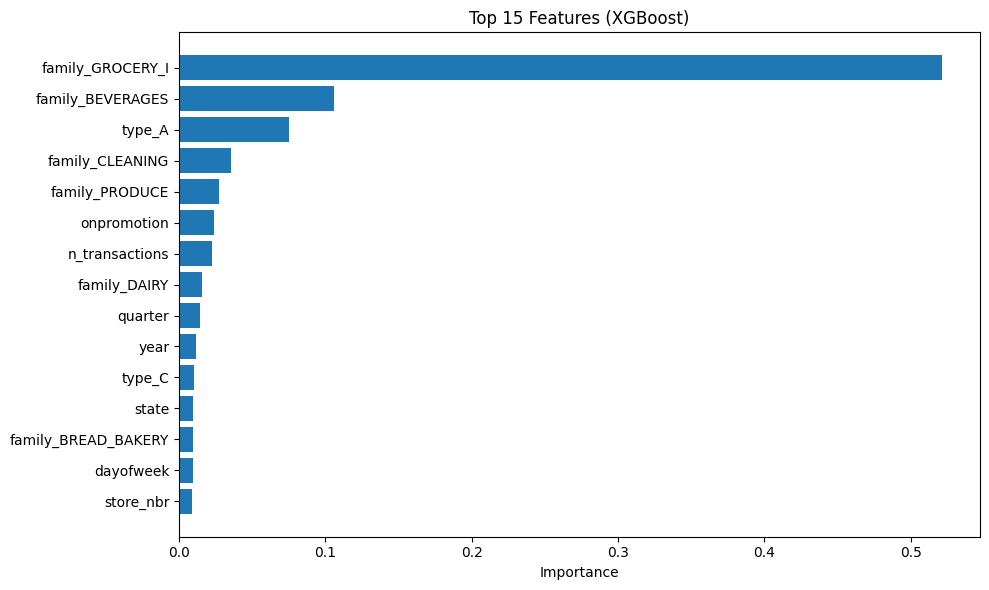

In [ ]:
# XGBoost 특성 중요도
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== XGBoost Top 10 중요 특성 ===")
print(xgb_importance.head(10))

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance.head(15)['feature'], xgb_importance.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 11. Test 데이터 예측

In [ ]:
# 최고 성능 모델로 Test 데이터 예측
if best_model_name == 'XGBoost':
    test_pred = xgb_model.predict(test_X)
    print("XGBoost 모델로 예측")
else:
    test_pred = lgb_model.predict(test_X)
    print("LightGBM 모델로 예측")

# 음수 예측값 처리
test_pred = np.clip(test_pred, 0, None)

print(f"\n예측값 통계:")
print(f"최소: {test_pred.min():.2f}")
print(f"최대: {test_pred.max():.2f}")
print(f"평균: {test_pred.mean():.2f}")
print(f"중앙값: {np.median(test_pred):.2f}")

XGBoost 모델로 예측

예측값 통계:
최소: 0.00
최대: 12938.61
평균: 461.19
중앙값: 78.64


## 12. 제출 파일 생성

In [ ]:
# 최적화된 모델로 제출 파일 생성
submission_opt = pd.DataFrame({
    'id': test_id,
    'sales': best_pred_opt
})

submission_opt.to_csv('submission_optimized.csv', index=False)

print("✓ submission_optimized.csv 생성 완료")
print(f"\n제출 파일 형식:")
print(submission_opt.head(10))
print(f"\n총 {len(submission_opt)}개의 예측값")
print(f"\n예측값 통계:")
print(f"최소: {best_pred_opt.min():.2f}")
print(f"최대: {best_pred_opt.max():.2f}")
print(f"평균: {best_pred_opt.mean():.2f}")
print(f"중앙값: {np.median(best_pred_opt):.2f}")


✓ submission.csv 생성 완료

제출 파일 형식:
        id        sales
0  3000888     0.000000
1  3000889     0.000000
2  3000890   126.460037
3  3000891  1986.222290
4  3000892     0.000000

총 28512개의 예측값


## 13. 전체 학습 데이터로 최종 모델 학습 (선택)

In [ ]:
# 전체 학습 데이터로 재학습 (더 좋은 성능을 위해)
print("전체 학습 데이터로 최종 모델 학습 중...")

final_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

final_model.fit(X, y, verbose=False)
final_test_pred = final_model.predict(test_X)
final_test_pred = np.clip(final_test_pred, 0, None)

# 최종 제출 파일
final_submission = pd.DataFrame({
    'id': test_id,
    'sales': final_test_pred
})

final_submission.to_csv('submission_final.csv', index=False)

print("✓ submission_final.csv 생성 완료")
print(f"\n최종 제출 파일 (전체 데이터 학습):")
print(final_submission.head())

전체 학습 데이터로 최종 모델 학습 중...
✓ submission_final.csv 생성 완료

최종 제출 파일 (전체 데이터 학습):
        id        sales
0  3000888     0.000000
1  3000889     0.000000
2  3000890     6.958533
3  3000891  2208.888672
4  3000892     0.000000


## 14. 예측값 분포 시각화

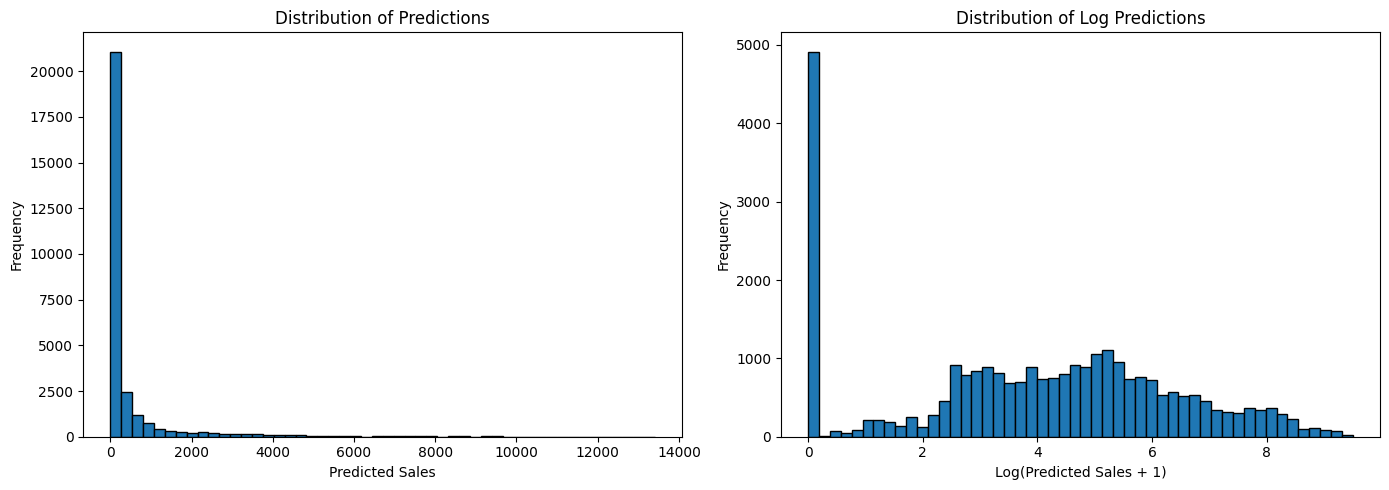

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(final_test_pred, bins=50, edgecolor='black')
axes[0].set_xlabel('Predicted Sales')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predictions')

# 로그 스케일
axes[1].hist(np.log1p(final_test_pred), bins=50, edgecolor='black')
axes[1].set_xlabel('Log(Predicted Sales + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log Predictions')

plt.tight_layout()
plt.show()

## 15. 완료 메시지

In [ ]:
print("\n" + "="*50)
print("모델 학습 및 예측 완료!")
print("="*50)
print(f"\n제출 가능한 파일:")
print("1. submission.csv - 검증 데이터로 테스트한 모델")
print("2. submission_final.csv - 전체 데이터로 학습한 모델 (권장)")
print(f"\n최고 검증 성능: {best_model_name} (RMSLE: {best_score:.6f})")
print("\nKaggle에 제출하세요!")


모델 학습 및 예측 완료!

제출 가능한 파일:
1. submission.csv - 검증 데이터로 테스트한 모델
2. submission_final.csv - 전체 데이터로 학습한 모델 (권장)

최고 검증 성능: XGBoost (RMSLE: 1.521931)

Kaggle에 제출하세요!
